In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random as random

/usr/local/Cellar/python/3.6.4_3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
PATH_TRAIN = './input/train.csv'
PATH_TEST = './input/test.csv'


def import_data(path_train, path_test):
    '''
    Import train data and test data from path.
    '''
    data_train = pd.read_csv(path_train).as_matrix()
    data_test = pd.read_csv(path_test).as_matrix()

    random.shuffle(data_train)
    random.shuffle(data_test)
    
    return data_train[:, 1:], data_train[:, 0:1].reshape(data_train.shape[0], 1),\
            data_test[:, 1:], data_test[:, 0:1].reshape(data_test.shape[0], 1)

def kernel_initializer(shape):
    '''
    Initial kernel in convolution layer or weight in full connection layer.
    '''
    initial = tf.truncated_normal(shape=shape, stddev=0.1, dtype="float32")
    return tf.Variable(initial_value=initial)

def bias_initializer(shape):
    initial = tf.constant(shape=shape, value=0, dtype="float32")
    return tf.Variable(initial_value=initial)
    

In [4]:
data_train, label_train, data_test, label_test = import_data(PATH_TRAIN, PATH_TEST)

# Divide to validation data
# 42000 = 4200 + 37800
data_valid = data_train[0:4200, :]
label_valid = label_train[0:4200, :].reshape([4200, 1])

data_train = data_train[4200:, :]
label_train = label_train[4200:, :].reshape([label_train.shape[0]-4200, 1])

In [5]:
## Prepare for the trainable variables.

# Convolution layer C1 trainable variables.
kernel_c1 = kernel_initializer((5, 5, 1, 6))
bias_c1 = bias_initializer((6, ))

# Subsample layer S2 trainable variables.
kernel_s2 = kernel_initializer((6,))
bias_s2 = bias_initializer((6,))

# Convolution layer C3 trainable variables.
kernel_c3 = kernel_initializer((5, 5, 6, 16))
bias_c3 = bias_initializer((16, ))

# Subsample layer S4 trainable variables.
kernel_s4 = kernel_initializer((16,))
bias_s4 = bias_initializer((16,))

# Convolution layer C5 trainable variables.
kernel_c5 = kernel_initializer((4, 4, 16, 120))
bias_c5 = bias_initializer((120,))

# Full connection layer F6 trainable variables.
kernel_f6 = kernel_initializer((120, 84))
bias_f6 = bias_initializer((84,))

# Full connection layer output trainable variables.
kernel_f7 = kernel_initializer((84, 10))
bias_f7 = bias_initializer((10,))



In [21]:
## Forward propapation (connect the graph).

batch = 420

# Make placeholder.
X = tf.placeholder(shape=(batch, 28, 28, 1), dtype="float32")
Y = tf.placeholder(shape=(1, batch), dtype="float32")

# Convolution layer 1, kernel = 5x5x6, output batchx24x24x6（add relu layer）
# X1 = tf.nn.conv2d(X, kernel_c1, strides=[1, 1, 1, 1], padding="VALID")+bias_c1
conv1 = tf.nn.conv2d(X, kernel_c1, strides=[1, 1, 1, 1], padding="VALID")
X1 = tf.nn.relu(tf.nn.bias_add(conv1, bias_c1))

# Subsample layer 2, output batchx12x12x6
# X2 = tf.nn.avg_pool(X1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")*kernel_s2+bias_s2
X2 = tf.nn.max_pool(X1, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# Convolution layer 3, kernel = 5x5x6x16, output batchx8x8x16
# X3 = tf.nn.conv2d(X2, kernel_c3, strides=[1, 1, 1, 1], padding="VALID")+bias_c3
conv3 = tf.nn.conv2d(X2, kernel_c3, strides=[1, 1, 1, 1], padding="VALID")
X3 = tf.nn.relu(tf.nn.bias_add(conv3, bias_c3))

# Subsample layer 4, output batchx4x4x16
#X4 = tf.nn.avg_pool(X3, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")*kernel_s4+bias_s4
X4 = tf.nn.max_pool(X3, [1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# Convolution layer 5, kernel = 4x4x16x120, output batchx1x1x120
conv5 = tf.nn.conv2d(X4, kernel_c5, strides=[1, 1, 1, 1], padding="VALID")
X5 = tf.nn.relu(tf.nn.bias_add(conv5, bias_c5))

X5_ = tf.reshape(X5, [-1, 120])

# Full Connection Layer 6, kernel = 1x1x120x84, output batchx1x1x84
X6 = tf.nn.relu(tf.matmul(X5_, kernel_f6)+bias_f6)

# Full Connection Layer 7, kernel = 84x10, output batchx1x1x10
X7 = tf.matmul(X6, kernel_f7)+bias_f7

# Compute loss and make optimite
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.reshape(tf.to_int64(Y), [batch, ]),\
                                             logits=X7)
# X7_ = tf.reduce_max(X7, axis=-1)
# loss = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = X7_)
optimite = tf.train.GradientDescentOptimizer(learning_rate=0.00002).minimize(loss)

# Compute accuracy
Y_ = tf.arg_max(X7, dimension=-1)
accuracy = 1-tf.count_nonzero(tf.to_int64(tf.squeeze(Y))-tf.squeeze(Y_))/batch


In [22]:
sess = tf.Session()
g_init = tf.global_variables_initializer()
sess.run(g_init)

In [27]:
for i in range(round(data_valid.shape[0]/batch)):
    acc = sess.run(accuracy, \
                 feed_dict={X: data_valid[i*batch:(i+1)*batch, :].reshape([batch, 28, 28, 1]),\
                            Y: label_valid[i*batch:(i+1)*batch].reshape([1, batch])})
    print(acc)

0.9976190476190476
0.9976190476190476
0.9928571428571429
1.0
0.9952380952380953
0.9904761904761905
0.9976190476190476
0.9952380952380953
0.9976190476190476
0.9833333333333333


In [25]:
# Train
epoch = 100
for train_epoch in range(epoch):
    accuracy_epoch = 0
    for i in range(round(data_train.shape[0]/batch)):
        _, acc = sess.run([optimite, accuracy], \
                                 feed_dict={X: data_train[i*batch:(i+1)*batch, :].reshape([batch, 28, 28, 1]),\
                                            Y: label_train[i*batch:(i+1)*batch].reshape([1, batch])})
        accuracy_epoch += acc
    print(accuracy_epoch/epoch)

0.8999047619047622
0.8999285714285716
0.8999523809523811
0.8999523809523811
0.8999523809523811
0.8999523809523811
0.8999523809523811
0.8999523809523811
0.8999523809523811
0.8999761904761905
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9
0.9


KeyboardInterrupt: 

In [161]:
# 0.1019285714285714
# 0.3799285714285714
# 0.7200952380952382
# 0.7826190476190475
# 0.811238095238095
# 0.8265952380952376
# 0.8364761904761905
# 0.8434761904761899
# 0.8490476190476192
# 0.8529999999999995
# 0.8569285714285715
# 0.8603571428571429
# 0.8635238095238092
# 0.8660952380952379
# 0.8684285714285711
# 0.8703571428571428
# 0.8723095238095236
# 0.8739523809523808
# 0.8758333333333329
# 0.8768571428571426
# 0.8779999999999998
# 0.8792380952380949
# 0.8802619047619045
# 0.8810476190476186
# 0.8818095238095234
# 0.8827142857142856
# 0.8837857142857141
# 0.8844761904761905
# 0.8853571428571427
# 0.8860714285714285
# 0.8866666666666666
# 0.887
# 0.8875476190476188
# 0.8880714285714284
# 0.8886190476190474
# 0.8890238095238093
# 0.8894999999999997
# 0.8902619047619047
# 0.8908809523809519
# 0.8915238095238093
# 0.8919047619047618
# 0.8921904761904758
# 0.8926904761904758
# 0.8930238095238089
# 0.8934047619047614
# 0.8937619047619044
# 0.894095238095238
# 0.8944285714285715
# 0.8947857142857144
# 0.8950238095238096
# 0.8953333333333334
# 0.8956190476190479
# 0.8957857142857142
# 0.8959523809523811
# 0.8961666666666666
# 0.8965238095238095
# 0.896857142857143
# 0.897047619047619
# 0.8972142857142856
# 0.8972619047619048
# 0.8975000000000002
# 0.8974523809523809
# 0.897619047619048
# 0.8977857142857146
# 0.8972380952380954
# 0.8976190476190479
# 0.897809523809524
# 0.8981904761904762
# 0.8982857142857144
# 0.8983571428571432
# 0.8982142857142857
# 0.8985476190476193
# 0.8970952380952381
# 0.8981190476190478
# 0.8986904761904766
# 0.8987857142857145
# 0.8980238095238096
# 0.8987142857142862
# 0.8985476190476193
# 0.8988809523809524
# 0.8989523809523812
# 0.8990952380952385
# 0.8991428571428574
# 0.8991904761904767
# 0.8992857142857146
# 0.8993333333333337
# 0.8993333333333337
# 0.8993809523809527
# 0.8994047619047622
# 0.8995000000000003
# 0.8994523809523813
# 0.8995000000000003
# 0.8995000000000003
# 0.8995714285714288
# 0.8995952380952386
# 0.8995952380952384
# 0.8996666666666671
# 0.8996666666666671
# 0.8996666666666671
# 0.899714285714286

<tf.Variable 'Variable_28:0' shape=(5, 5, 1, 6) dtype=float32_ref>


In [27]:
import matplotlib.pyplot as plt

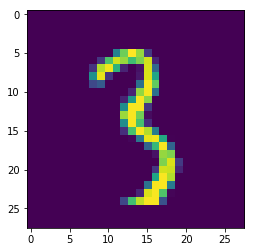

In [74]:
plt.imshow(X=data_train[3423, :].reshape([28, 28]))
plt.show()

In [76]:
label_train.reshape([label_train.shape[0], 1])[3423]

array([3])